In [4]:
pip install keras-ocr

Note: you may need to restart the kernel to use updated packages.


Looking for /Users/admin/.keras-ocr/craft_mlt_25k.h5
Metal device set to: Apple M1 Pro


2022-12-13 12:24:26.250330: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-13 12:24:26.250571: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Looking for /Users/admin/.keras-ocr/crnn_kurapan.h5


2022-12-13 12:24:27.840214: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-13 12:24:28.018441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 820ms/step


2022-12-13 12:24:29.328944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-13 12:24:29.748623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-13 12:24:29.756520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-13 12:24:29.905012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-13 12:24:29.912046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


True

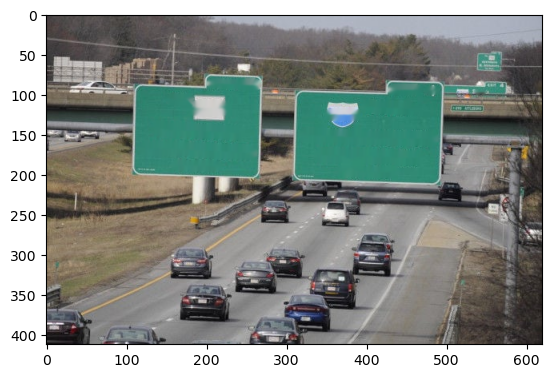

In [1]:
import matplotlib.pyplot as plt
import keras_ocr
import cv2
import math
import numpy as np

#General Approach.....
#Use keras OCR to detect text, define a mask around the text, and inpaint the
#masked regions to remove the text.
#To apply the mask we need to provide the coordinates of the starting and 
#the ending points of the line, and the thickness of the line

#The start point will be the mid-point between the top-left corner and 
#the bottom-left corner of the box. 
#the end point will be the mid-point between the top-right corner and the bottom-right corner.
#The following function does exactly that.
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

#Main function that detects text and inpaints. 
#Inputs are the image path and kreas_ocr pipeline
def inpaint_text(img_path, pipeline):
    # read the image 
    img = keras_ocr.tools.read(img_path) 
    
    # Recogize text (and corresponding regions)
    # Each list of predictions in prediction_groups is a list of
    # (word, box) tuples. 
    prediction_groups = pipeline.recognize([img])
    
    #Define the mask for inpainting
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        #For the line thickness, we will calculate the length of the line between 
        #the top-left corner and the bottom-left corner.
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        #Define the line and inpaint
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        inpainted_img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                 
    return(inpainted_img)

# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

img_text_removed = inpaint_text('sign.jpg', pipeline)

plt.imshow(img_text_removed)

cv2.imwrite('sign-remove.jpg', cv2.cvtColor(img_text_removed, cv2.COLOR_BGR2RGB))